# Cox Proportional Hazards

* In contrast to Kaplan-Meier, Cox Proportional Hazards can be used for multi-variate analysis.

* Similar to Kaplan-Meier, Cox Proportional Hazards can be used to plot survival probability curves but the way it is done differs mathematically. The result is referred to as adjusted survival probability curves because you adjust for other covariates.

## The Cox Proportional Hazards Equation
* Whereas Kaplan-Meier is used to estimate the probability of survival, Cox Proportional Hazards is used to estimate the hazard ratio. The hazard ratio represents the difference in hazard that exists between two individuals (or groups). The hazard is essentially the inverse of survival, or the probability of failure. The fact that Kaplan-Meier estimates the probability of survival whereas Cox Proportional Hazards estimates a hazard ratio is not a concern because as long as you have one, you can calculate the other. The Lifelines library makes this easy to do.

* The Cox Proportional Hazards equation states that the hazard ratio is the product of two terms: the baseline hazard and the partial hazard.

* The baseline hazard is simply a baseline. It's the hazard that exists when each variable is set to a specific value. For example:

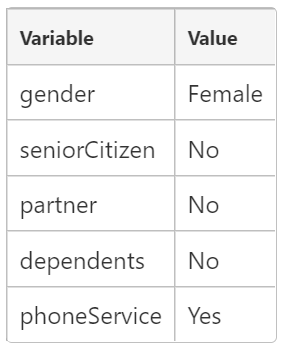

* The partial hazard represents the change in the hazard that occurs when the value for a variable is different from the baseline. At any given time, zero or more variables can contain a value different from the baseline. As seen in the equation below, the resulting change in the hazard is a linear combination of the parameters / variables.

* If every variable were set to its corresponding baseline value, then the partial hazard would equal 1 (since e^0 = 1) and the hazard ratio would equal the baseline hazard.

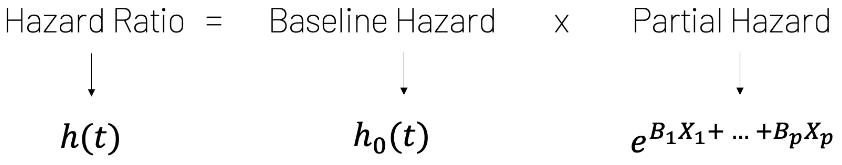

## The Proportional Hazards Assumption
* A subtle but critical element of the Cox Proportional Hazard equation is that the baseline hazard is a function of time t, but not the parameters, whereas the partial hazard is a function of the parameters, but not time. This underpins what is referred to as the proportional hazard assumption.

* The proportional hazard assumption states that in the context of a Cox Proportional Hazard model, the hazard ratio between two groups is proportional over time. This assumption is implicit in the equation above because the lack of t in the partial hazard means that the partial hazard changes the hazard ratio by some factor, independent of time.

> Image below shows the proportional vs not-proportional ratio over time

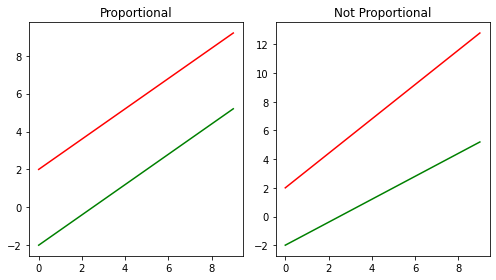

In [1]:
import matplotlib.pyplot as plt

a = [0.8*i + (-2) for i in range(10)]
b = [0.8*i + (2) for i in range(10)]
c = [1.2*i + (2) for i in range(10)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
axes[0].plot(a,'g-', b, 'r-')
axes[0].title.set_text('Proportional')
axes[1].plot(a,'g-', c, 'r-')
axes[1].title.set_text('Not Proportional')
fig.tight_layout()

#### Setup

In [2]:
! pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 13.4 MB/s 
     |████████████████████████████████| 68 kB 6.7 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=e3013704995be5a8a45ee89ae214b0c46d08a77fa845f590d14c1e64d14eac82
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [3]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np

from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

In [4]:
! wget https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

--2022-08-05 18:40:47--  https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 970457 (948K) [text/plain]
Saving to: ‘Telco-Customer-Churn.csv’

Telco-Customer-Chur 100%[===================>] 947.71K  --.-KB/s    in 0.02s   

2022-08-05 18:40:48 (48.0 MB/s) - ‘Telco-Customer-Churn.csv’ saved [970457/970457]



1. Read the data
2. Filter to internet subscribers with a month-to-month contract
3. Convert Churn column to a boolean

In [5]:
df = pd.read_csv('/content/Telco-Customer-Churn.csv')

# To keep the analysis focused, let's just filter to internet subscribers with a month-to-month contract
df = df[df['Contract'] == 'Month-to-month']

df = df[df['InternetService'] != 'No']

# Convert Churn column to a boolean
df['Churn'] = df['Churn'].replace(to_replace=['No', 'Yes'], value=[0, 1])

print('Data Shape : ', df.shape)
df.head()

Data Shape :  (3351, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0


### One-Hot Encode the Categorical Variables
* In order to fit a Cox Proportional Hazards model using the Lifelines library, you must first one-hot encode your categorical columns. We have hand-selected 5 variables to use for this notebook.

* After one-hot encoding the variables, we then created a new dataframe consisting of only the columns we need to fit the model.

* When creating the dataframe that you will use to fit the model, it is important that you drop one column for each one-hot encoded variable. For example, we included dependents_yes and dropped dependents_no. If you neglect to do this, you will likely receive an error when fitting the model that states that there are multi-collinearity issues with your data. This means that certain columns are highly correlated. For example, if you know that dependents_yes = 1 then you in turn know that dependents_no = 0.

* You can take one of two approaches when dropping variables. When using Pandas' get_dummies() function, you can simply set drop_first = True. An alternative approach, which is the one taken here, is to hand-select which variables to drop. In this notebook, we dropped the value that had a Kaplan-Meier survival probability curve most similar to the population. While this is by no means necessary, it affords an intuitive interpretation as the baseline closely resembles the population.

In [6]:
# Encode columns of interest
encode_cols = ['Dependents','InternetService','OnlineBackup','TechSupport','PaperlessBilling']
 
encoded_pd = pd.get_dummies(df,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)
 
encoded_pd.head()

,customerID,gender,SeniorCitizen,Partner,tenure,PhoneService,MultipleLines,OnlineSecurity,DeviceProtection,StreamingTV,...,Dependents_No,Dependents_Yes,InternetService_DSL,InternetService_Fiber optic,OnlineBackup_No,OnlineBackup_Yes,TechSupport_No,TechSupport_Yes,PaperlessBilling_No,PaperlessBilling_Yes
0,7590-VHVEG,Female,0,Yes,1,No,No phone service,No,No,No,...,1,0,1,0,0,1,1,0,0,1
2,3668-QPYBK,Male,0,No,2,Yes,No,Yes,No,No,...,1,0,1,0,0,1,1,0,0,1
4,9237-HQITU,Female,0,No,2,Yes,No,No,No,No,...,1,0,0,1,1,0,1,0,0,1
5,9305-CDSKC,Female,0,No,8,Yes,Yes,No,Yes,Yes,...,1,0,0,1,1,0,1,0,0,1
6,1452-KIOVK,Male,0,No,22,Yes,Yes,No,No,Yes,...,0,1,0,1,0,1,1,0,0,1


In [7]:
# Create new dataframe consisting of only the variables needed to fit the model
survival_pd = encoded_pd[['Churn','tenure','Dependents_Yes','InternetService_DSL','OnlineBackup_Yes','TechSupport_Yes']]

In [8]:
# Cast churn column as a float
survival_pd.loc[:,'Churn'] = survival_pd.loc[:,'Churn'].astype('float')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Fit the Cox Proportional Hazards Model
* Similar to Kaplan-Meier, the first step when using the Lifelines library for Cox Proportional Hazards is to fit the model.

* When fitting the model, we specified alpha = 0.05. This means that we will use a 95% confidence interval for our statistical tests.

* We provided three parameters to the fitted model:

  1. suvival_pd: the dataframe used to fit the model
  2. Tenure: the duration that a customer has been with the company (if still a subscriber) or was with the company prior to churning.
  3. Churn: a Boolean indicating whether the customer is still a subscriber or not.

In [9]:
cph = CoxPHFitter(alpha=0.05)
cph.fit(survival_pd, 'tenure', 'Churn')

<lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>

### Assess the Results of the Fitted Model
There are three key questions to ask when initially assessing the model:

1. <u>Is each covariate statistically significant?</u>

In the column labeled p below, it can be seen that the p-value for each column is below < 0.005. Therefore, each of the columns is statistically significant and safe to include.
Similar to other forms of regression, in the event that a variable is not statistically significant, you can drop that column from your analysis or recategorize the corresponding values.

2. <u>How confident are we in the coefficient estimates?</u>

Upper and lower bounds for each coefficient and exp(coefficient) are provided in the model summary below (e.g. exp(coef) lower 95%, exp(coef) upper 95%).
Shown below the model summary, these bounds can also be viewed visually. Although it's not seen here, note that when viewing the bounds in this way, a variable can be deemed as not signficant when its corresponding box-and-whisker plot crosses the value 1.

3. <u>What is the effect of each covariate on the hazard ratio?</u>

Using internetService_DSL as an example, it's shown below that coef = -0.22 and exp(coef) = 0.80. Referring back to the Cox Proportional Hazards equation, this means that a customer's hazard ratio decreases by a factor of 0.80 (versus the baseline) when they subscribe to DSL for their internet service.
Note that this output also includes several metrics that can be used when comparing models:
1. Concordance
2. Partial AIC
3. Log-likelihood Ratio

In [10]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 3351
number of events observed = 1556
   partial log-likelihood = -11315.95
         time fit was run = 2022-08-05 18:40:48 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
Dependents_Yes       -0.33       0.72       0.07            -0.47            -0.19                 0.63                 0.83
InternetService_DSL  -0.22       0.80       0.06            -0.33            -0.10                 0.72                 0.90
OnlineBackup_Yes     -0.78       0.46       0.06            -0.89            -0.66                 0.41                 0.52
TechSupport_Yes      -0.64       0.53       0.08            -0.79            -0.49                 0.46                 0.61

                      cmp to      z      p   -log2(p)
covariate                                            
Dependents_Yes          0.00  -4.64 <0.005      18.12
InternetService_DSL     0.00  -3.68 <0.005      12.07
OnlineBackup_Yes        0.00 -13.13 <0.005     128.37
TechSupport_Yes         0.00  -8.48 <0.005      55.36
---
Concordance = 0.64
Partial AIC = 22639.90
log-likelihood ratio test = 337.77 on 4 df
-log2(p) of ll-ratio test = 236.24

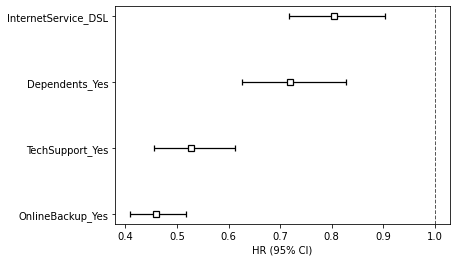

In [11]:
cph.plot(hazard_ratios=True);

### Verify if the Model Adheres to the Proportional Hazard Assumption
* After assessing the results of the fitted model, the next step is to verify whether the model adheres to the proportional hazard assumption. We will do this using three methods:

  * Method 1: Statistical Test
  * Method 2: Schoenfield Residuals
  * Method 3: Log-log Kaplan-Meier Plots

* The results of using the first method -- a statistical test -- are shown below. As seen in the printout, Lifelines provides quite a bit of detail, including test results and recommendations. In the case of this model, it is seen that we violate the proportional hazard assumption for three of the four variables. This is illustrated by the p-values being less than 0.05 as well as the text below it. Of note, as hinted in the closing thoughts section of the Kaplan-Meier notebook, a red flag for this scenario is when you see the survival curves for a given covariate crossover each other when using Kaplan-Meier.

In [12]:
cph.check_assumptions(survival_pd,p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic      p  -log2(p)
Dependents_Yes      km              1.48   0.22      2.16
                    rank            0.81   0.37      1.44
InternetService_DSL km             20.98 <0.005     17.72
                    rank           26.71 <0.005     22.01
OnlineBackup_Yes    km             17.80 <0.005     15.31
                    rank           17.47 <0.005     15.07
TechSupport_Yes     km              8.09 <0.005      7.81
                    rank           13.76 <0.005     12.23



1. Variable 'InternetService_DSL' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['InternetService_DSL', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'OnlineBackup_Yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['OnlineBackup_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

3. Variable 'TechSupport_Yes' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['TechSupport_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://l

[]

### Schoenfeld Residuals
* In addition to running a statistical test, it is helpful to also leverage a graphical output to assess the situation. This can be done using Schoenfeld residuals.

* In the output below, there are two plots for each variable. The difference between these two plots is the order in which the residual values are displayed: Rank tranformed time and KM-transformed time. No material difference is seen between these two types of plots for our model.

* The way to interpret these plots is similar to the way you would interpret residual plots for linear regression. In other words, when viewing this type of plot, we do not want to see any sort of pattern in the residuals. When no pattern is present, the black line in the middle will be relatively flat, indicating that the residuals are not correlated with time.

* internetService_DSL: clear and consistent trend across time.

* onlineBackup_Yes: most pronounced trend of the three variables.

* techSupport_Yes: there is a bit of a pattern seen across time but the most profound impact comes from the points near the end of the timeline.

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic      p  -log2(p)
Dependents_Yes      km              1.48   0.22      2.16
                    rank            0.81   0.37      1.44
InternetService_DSL km             20.98 <0.005     17.72
                    rank           26.71 <0.005     22.01
OnlineBackup_Yes    km             17.80 <0.005     15.31
                    rank           17.47 <0.005     15.07
TechSupport_Yes     km              8.09 <0.005      7.81
                    rank           13.76 <0.005     12.23



1. Variable 'InternetService_DSL' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['InternetService_DSL', ...]`
in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'OnlineBackup_Yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['OnlineBackup_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'TechSupport_Yes' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['TechSupport_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assump

[[<matplotlib.axes._subplots.AxesSubplot at 0x7f6fdebbd050>,

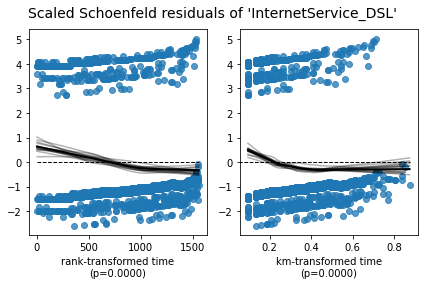

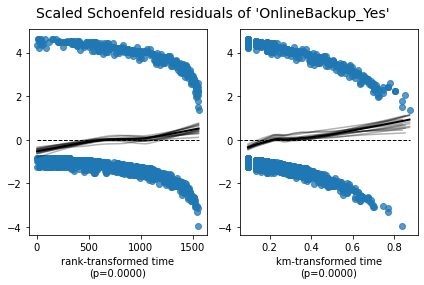

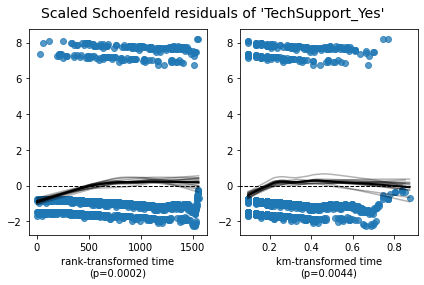

In [13]:
cph.check_assumptions(survival_pd,p_value_threshold=0.05,show_plots=True)

### Log-log Kaplan-Meier Plots
* Based on the results of the statistical test and the Schoenfeld residual plots, it's clear that our model violates the proportional hazards assumption many times over.

* To get another view of what the issue at play is here, we can use log-log Kaplan-Meier plots. As the name implies, this technique plots Kaplan-Meier curves on a log-log scale.

* It's important to note that this transformation of the Kaplan-Meier curves is simply altering the scale in which we view the data. This effectively smushes the data closer together, making it easier to assess.

* When the proportional hazard assumpton is not violated, the Kaplan-Meier curves in the log-log plot will appear parallel. This is in line with the plots reviewed above in the section "proportional hazard assumption."

* With the exception of internetService, it can be seen in the plots below that the Kaplan-Meier curves are mostly* parallel when log(timeline) is between 1 and 3 but less so when the log(timeline) is less than 1 or greater than 3.

In [14]:
# Fit the Kaplan-Meier model
kmf = KaplanMeierFitter()
 
T = df['tenure'] #duration
C = df['Churn'].astype(float) #event observed
 
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3351 total observations, 1795 right-censored observations>

In [15]:
# Utility function for plotting
import matplotlib.pyplot as plt
def plot_km_loglog(col):
  ax = plt.subplot(111)
  for r in df[col].unique():
    ix = df[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    kmf.plot_loglogs(ax=ax)

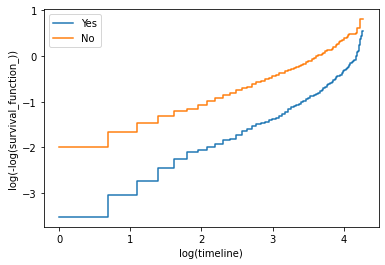

In [17]:
plot_km_loglog('OnlineBackup')

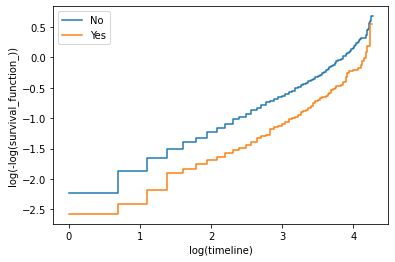

In [19]:
plot_km_loglog('Dependents')

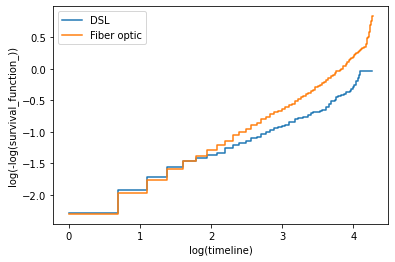

In [20]:
plot_km_loglog('InternetService')

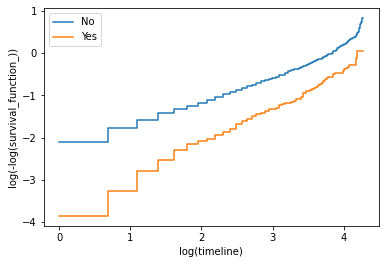

In [21]:
plot_km_loglog('TechSupport')

### Summary

* Cox Proportional Hazards is one of the most popular methods for Survival Analysis. This is in part due to CPH being a semi-parametric model, which means that your outcome variable does not need to adhere to a specific distribution. Further, CPH is known to fit various distributions fairly well.

* As discussed above, the key assumption that underpins this method is referred to as the proportional hazards assumption. In the event that this assumption is violated, as is the case here, you have a number of options: 

1. `Leave the model as-is`: it's important to note that this assumption is most important when your objective is inference. If your objective is prediction, you can generally focus on the loss metric as your means for selecting a final model.

2. `Stratify the existing model`: if there are a small number of variables causing the issue, you can stratify your model on those variables. The net result of using this approach is that you will have a different baseline hazard for each variable that you stratify the model on. Lifelines makes this easy to incorporate.

3. `Incoporate time-dependent variables`: as noted when reviewing the Cox Proportional Hazards equation, the partial hazard is time-independent. More specifically, the baseline hazard is a function of time and then the partial hazard is a function of the parameters. When a variable is truly time-dependent, it can be modeled as such using an interaction variable. This is referred to as the Extended Cox Proportional Hazards model.

4. `Use Cubic Splines or Piecewise Constant Hazards`: similar to other regression techniques, you can use cubic splines to add more flexibility to your model. You can think of this as splitting your model into multiple parts. For example, in our model above, it's clear that we see different patterns at certain points in time. What if there were 'knots' at these turning points, enabling your to alter your specification? In the context of Cox Proportional Hazards, using Cubic Splines results in the baseline hazard becoming parametric.

5. `Use a Different Method`: although the Cox Proportional Hazards method can be extended in many ways, inclusive of a fully parametric form (e.g. Cubic Splines), it's important to know that other Survival Analysis methods exist. One alternative method is the Accelerated Failure Time model. The Accelerated Failure Time model is fully parametric and can be modeled using various distributions such as Exponential and Weibull. Note that this distribution refers to the shape of the outcome variable.